# openCV to read AVI, detect Volvox


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd


In [9]:
plt.rcParams['figure.figsize'] = [15, 15]

In [2]:
def rescaleData(data, mindata=0, maxdata=1):
	return np.interp(data, (data.min(), data.max()), (mindata, maxdata))

In [3]:
avifile='/media/hydroassist/Volvox m2/20200615rs.avi'

In [4]:
capture = cv2.VideoCapture(avifile)
backSub = cv2.createBackgroundSubtractorMOG2()

if not capture.isOpened:
    print('Unable to open: ' + file)
    exit(0)
print('width=' ,capture.get(cv2.CAP_PROP_FRAME_WIDTH))
print('height=',capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
totalN = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
print('length=',totalN)
cv2.namedWindow("Frame",0);
cv2.resizeWindow("Frame", 1500, 500);
cv2.namedWindow("background",0);
cv2.resizeWindow("background", 1500, 500);

# while True:
for j in range(1):
    capture = cv2.VideoCapture(avifile)
    for ID in range(60,1060):
        capture.set(cv2.CAP_PROP_POS_FRAMES, ID)
        ret, frame = capture.read()
        if frame is None:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        fgMask = backSub.apply(gray)
        bgimg = backSub.getBackgroundImage()

        
        cv2.rectangle(frame, (10, 2), (300,60), (255,255,255), -1)
        cv2.putText(frame, str(capture.get(cv2.CAP_PROP_POS_FRAMES)), (10, 40), cv2.FONT_HERSHEY_TRIPLEX, 2 , (0,0,0),3)
        cv2.imshow('Frame', frame)
        cv2.imshow('background', bgimg)
#         cv2.imshow('FG Mask', fgMask)


        keyboard = cv2.waitKey(30)
        if keyboard == 'q' or keyboard == 27:
            break
capture.release()  
cv2.destroyAllWindows() 

width= 2048.0
height= 1808.0
length= 3551


In [ ]:
# capture.release()
# cv2.destroyAllWindows()

In [5]:
imgbg = bgimg.copy()

In [6]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))

In [53]:
cv2.namedWindow("detected circles",0);
cv2.resizeWindow("detected circles", 1000, 1000);

cap = cv2.VideoCapture(avifile)
nframes = 1000
data=np.array([[0,0,0,0]]) # x,y, radius,frameID
for frameID in range(0,100):
    cap.set(1,frameID) # (1, # of frame)
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    imgdiff=gray.astype(float)-imgbg.astype(float)
    imgdiff[np.where(imgdiff<0)]=0
    imgrescale = rescaleData(imgdiff, mindata=0, maxdata=255)
    imgrescale = imgrescale.astype('uint8')
    ret,thimg = cv2.threshold(imgrescale,30,255,cv2.THRESH_BINARY_INV)
    closingimg = cv2.morphologyEx(thimg,cv2.MORPH_CLOSE,kernel)
    closingimg = cv2.morphologyEx(closingimg,cv2.MORPH_CLOSE,kernel)
    circles = cv2.HoughCircles(closingimg,cv2.HOUGH_GRADIENT,1,10,param1=50,param2=6,minRadius=2,maxRadius=5)
    outputimg = frame.copy()

    for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(outputimg,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv2.circle(outputimg,(i[0],i[1]),2,(0,0,255),3)
        cv2.rectangle(outputimg, (10, 2), (300,60), (255,255,255), -1)
        cv2.putText(outputimg, str(cap.get(cv2.CAP_PROP_POS_FRAMES)), (10, 40), cv2.FONT_HERSHEY_TRIPLEX, 2 , (0,0,0),3)
    cv2.imshow('detected circles',outputimg)
    cv2.waitKey(10)

    tempdata = np.append(circles[0],np.array([[frameID]*circles[0].shape[0]]).T,axis=1)
    data=np.append(data,tempdata,axis=0)
data = np.delete(data,0,0)
dataset = pd.DataFrame({'x':data[:,0],'y':data[:,1],'radius':data[:,2],'frame':data[:,3]})

cap.release()
cv2.destroyAllWindows()

In [61]:
cap.release()
cv2.destroyAllWindows()

# trackpy to create the trajectory

In [24]:
import trackpy as tp

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [45]:
datalink = tp.link_df(dataset,30, memory=10)

Frame 99: 636 trajectories present.


In [27]:
datalink.head()

frame  radius      x       y  particle
0        0     4.4  684.5  1190.5         0
436      0     3.0  285.5  1217.5         1
437      0     3.0  340.5    69.5         2
438      0     3.0  399.5   934.5         3
439      0     3.0  430.5   236.5         4

In [49]:
def distance2D(x,y):
	return ((x[1:]-x[0:-1])**2+(y[1:]-y[0:-1])**2)**0.5

def velocity2D(x=[],y=[],t=[]):
	return (((x[1:]-x[0:-1])**2+(y[1:]-y[0:-1])**2)**0.5)/(t[1:]-t[0:-1])

In [50]:
IDcounts = []
meanR = []
stdR = []
meanV = [] 
stdV = []
ID = []
travelL = []
absV = []
maxmove = []
for vID in range(max(datalink['particle'])):
    filterid = (datalink['particle']==vID)
    IDcounts.append(datalink[filterid].shape[0])
    x=datalink[filterid]['x'].values
    y=datalink[filterid]['y'].values
    t=datalink[filterid]['frame'].values
    r=datalink[filterid]['radius'].values
    meanR.append(r.mean())
    stdR.append(r.std())
    meanV.append(velocity2D(x=x,y=y,t=t).mean())
    stdV.append(velocity2D(x=x,y=y,t=t).std())
    travelL.append(np.sum(distance2D(x,y)))
    absV.append(np.sum(distance2D(x,y))/(max(t)-min(t)))
    maxmove.append(max((max(x)-min(x)),(max(y)-min(y))))
    ID.append(vID)
    
trackinfo = pd.DataFrame({'IDcounts':IDcounts,'meanR':meanR,'stdR':stdR,'meanV':meanV,'stdV':stdV,'absV':absV,'travelL':travelL,'maxmove':maxmove,'ID':ID})

/home/hydroassist/.local/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/hydroassist/.local/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


In [51]:
filterlink = tp.filter_stubs(datalink, 100)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', datalink['particle'].nunique())
print('After:', filterlink['particle'].nunique())

Before: 2703
After: 10


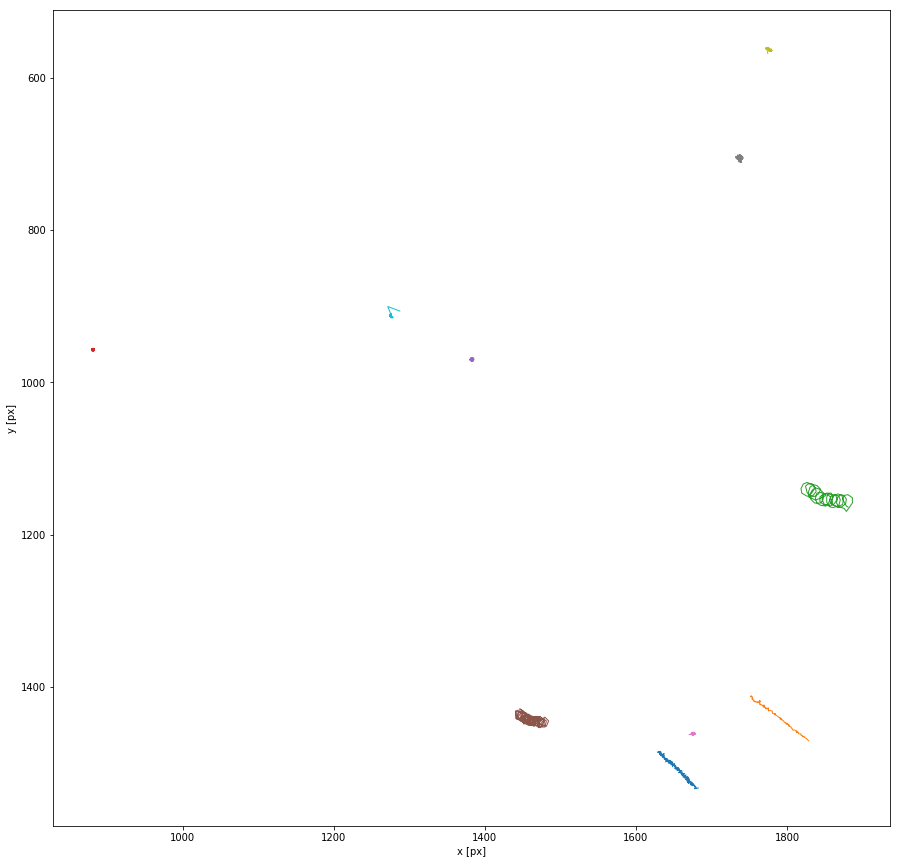

In [52]:
plt.figure(figsize=(15,15))
plt.subplot(1,1,1)
tp.plot_traj(filterlink, label=False)


In [ ]:
filterid = (datalink['particle']==19)
x=datalink[filterid]['x'].values
y=datalink[filterid]['y'].values

plt.plot(x,y)
plt.show()

In [ ]:
filterinfo = trackinfo.loc[(trackinfo['IDcounts'] >= 200)].loc[(trackinfo['maxmove'] >= 50)].sort_values(by='IDcounts',ascending=False)

In [ ]:
filterinfo.head()

In [ ]:
# %%script false
plt.figure(figsize=(15,15))
for i in filterinfo['ID'].values:
    filterid = (datalink['particle']==i)
    x=datalink[filterid]['x'].values
    y=datalink[filterid]['y'].values
    plt.plot(x,y)
    plt.xlim([0,imgW])
    plt.ylim([0,imgH])
    plt.gca().invert_yaxis()
plt.savefig(imgfile[:-4]+'_trace.jpg')
plt.show()

In [ ]:
plt.plot(filterinfo['meanR'],filterinfo['absV'],'o')
plt.show()

In [ ]:
plt.plot(filterinfo['meanR'],filterinfo['meanV'],'o')
plt.show()

In [ ]:
# %%script false
trackfile=imgfile[:-4]+'_track.pkl'
trackinfofile=imgfile[:-4]+'_trackinfo.pkl'

datalink.to_pickle(trackfile)
trackinfo.to_pickle(trackinfofile)